In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
#tradeable

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df["symbol"] = pd.Series([asset.symbol for asset in assets])
#asset_info_df.sort_values("symbol", inplace=True)

# Display the first 10 asset tickers
asset_info_df.head(10)

,symbol
0,AAME
1,AAOI
2,AAU
3,AAVVF
4,AB
5,ACGL
6,ACGLO
7,ACH
8,ADMA
9,AFMD


In [5]:
# Set the ticker
ticker = input("Enter the ticker to run the Monte Carlo Simulation")

# Set timeframe to "1D"
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-03-20", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-03-20", tz="America/New_York").isoformat()

# Get 1 year"s worth of historical data for the desired stock
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.tail()

Enter the ticker to run the Monte Carlo Simulation BNS


BNS                              
                            open   high    low  close   volume
2020-03-16 00:00:00-04:00  36.87  40.19  36.77  37.58  3067294
2020-03-17 00:00:00-04:00  38.08  39.27  35.92  37.91  2086529
2020-03-18 00:00:00-04:00  36.14  36.66  33.09  34.93  2322084
2020-03-19 00:00:00-04:00  34.24  35.21  33.18  35.04  1783683
2020-03-20 00:00:00-04:00  36.27  38.44  34.12  34.82  2206107

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)


# Use the drop function to drop extra columns
df.drop(columns=["open", "high", "low", "volume"], inplace=True)


# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.tail()

,close
2020-03-16,37.58
2020-03-17,37.91
2020-03-18,34.93
2020-03-19,35.04
2020-03-20,34.82


In [7]:
# Use the `pct_change` function to calculate daily returns of BB
daily_returns = df.pct_change()

# Use the `mean` function to calculate the mean of daily returns for BB
avg_daily_return = daily_returns.mean()["close"]

# Use the `std` function to calculate the standard deviation of daily returns for BB
std_dev_daily_return = daily_returns.std()["close"]

In [8]:
# Set number of trading days and get last closing price of stoock from DataFrame
num_simulations = 1000
num_trading_days = 81 
stock_last_price = df["close"][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):
    # Initialize the simulated prices list with the last closing price of TSLA
    simulated_ticker_prices = [stock_last_price]

        # Simulate the returns for 81  trading days (till 20th july 2020)
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_ticker_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_ticker_prices.append(simulated_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_ticker_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,...,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000
1,34.358089,35.081734,34.602606,35.121310,34.982525,33.905621,34.270891,35.975350,34.495704,34.630560,...,35.440958,33.254886,34.147323,34.423268,34.074829,35.957846,34.794541,34.078807,35.419482,34.942277
2,33.402449,34.776660,33.878710,34.350801,35.835930,32.627585,34.661517,34.756025,33.887847,34.095092,...,36.071770,34.471026,33.452921,33.862591,34.983924,36.373097,35.232394,33.108006,34.800469,35.907681
3,32.408739,35.979102,34.318643,33.805595,35.880571,32.975643,34.041885,33.057258,33.161291,34.649418,...,35.288727,33.497644,33.773591,33.102672,34.554101,36.576042,35.349091,31.878734,34.840071,36.555606
4,31.599091,35.899990,34.279202,34.323109,35.705784,34.092080,33.753654,33.243993,33.302399,33.713955,...,34.722101,34.412864,34.150310,33.322929,34.472058,37.188506,35.692405,32.205855,35.867922,35.212586


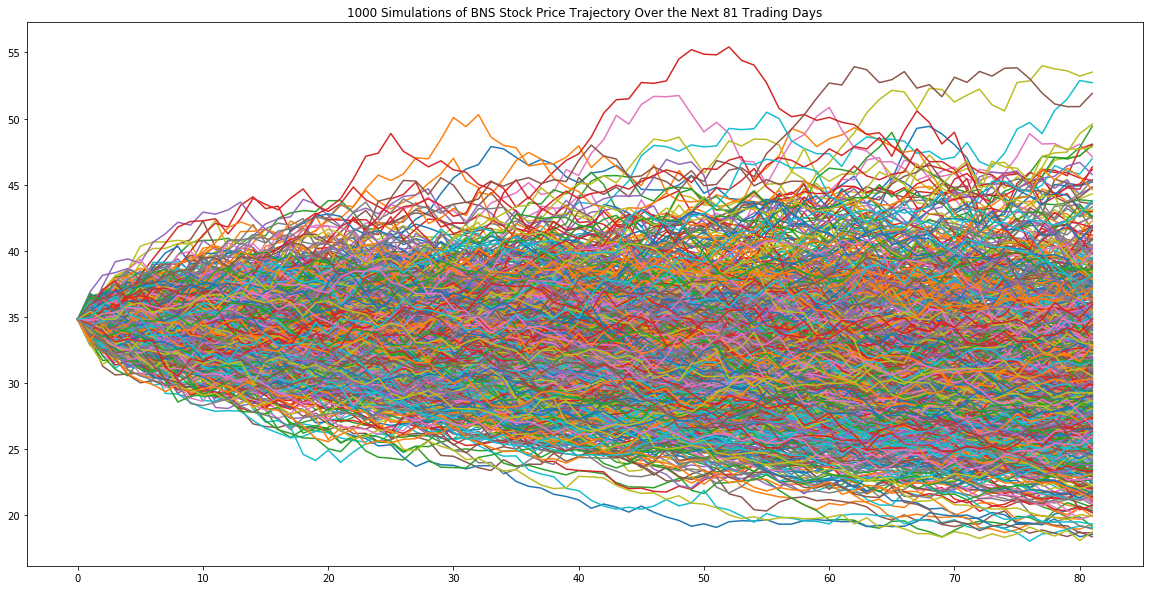

In [9]:
# Use the `plot` function to plot the trajectory of given stock based on a 81 trading day simulation
plot_title = f"{n+1} Simulations of {ticker} Stock Price Trajectory Over the Next 81 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title, figsize =[20,10])

In [10]:
# Select the last row for projecting stock prices (prices of each simulation on the last simulated trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulation 1    24.665895
Simulation 2    31.031065
Simulation 3    28.615097
Simulation 4    30.928969
Simulation 5    36.746044
Name: 81, dtype: float64

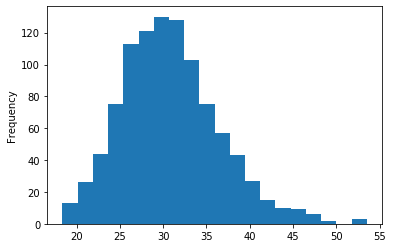

In [11]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind='hist', bins=20)

In [12]:
# Use the `value_counts` function to create the frequency distribution and 
# sort the data into 20 bins. Divide the value counts of each bin by the total
# number of prices to return the probability of each range
simulated_ending_prices.value_counts(bins=20) / len(simulated_ending_prices)

(28.906, 30.664]                0.130
(30.664, 32.421]                0.128
(27.149, 28.906]                0.121
(25.391, 27.149]                0.113
(32.421, 34.179]                0.103
(34.179, 35.937]                0.075
(23.633, 25.391]                0.075
(35.937, 37.694]                0.057
(21.876, 23.633]                0.044
(37.694, 39.452]                0.043
(39.452, 41.209]                0.027
(20.118, 21.876]                0.026
(41.209, 42.967]                0.015
(18.323999999999998, 20.118]    0.013
(42.967, 44.725]                0.010
(44.725, 46.482]                0.009
(46.482, 48.24]                 0.006
(51.755, 53.513]                0.003
(48.24, 49.997]                 0.002
(49.997, 51.755]                0.000
Name: 81, dtype: float64

In [13]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices.quantile(q=[0.025, 0.975])
confidence_interval

0.025    21.206010
0.975    43.549226
Name: 81, dtype: float64

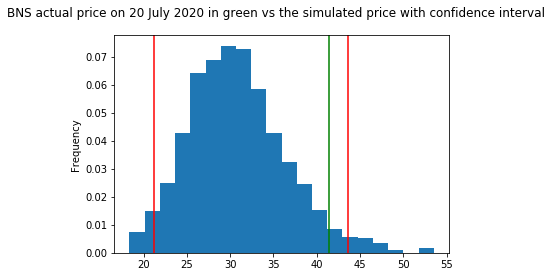

In [14]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
simulated_ending_prices.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

#Plot the actual price on 20th July of the stock

# Set timeframe to "1D"
timeframe = "1D"

# Set the dates for the price of the desired stock for 20 July 2020
start_date = pd.Timestamp("2020-07-19", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-07-20", tz="America/New_York").isoformat()

# Get actual stock price for the desired stock on 20th July 2020
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
    ).df

title_plot = (f"{ticker} actual price on 20 July 2020 in green vs the simulated price with confidence interval")
plt.suptitle(title_plot)
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)


actual_price = df["close"]

plt.axvline(actual_price.iloc[0], color='g')
